# 【プロダクト演習】

## 概要
過去の株価情報をもとにLSTMを使った時系列予測を試みる。


**【データ】**  
yahoo!Finance（https://finance.yahoo.com/）からダウンロードとした日経225の終値をベースとする

**【予測情報】**  
過去の株価からX営業日後の株価の上昇/下降率を予測する。
具体的には「1%以上、0%以上1%未満、0%以下-1%より上、-1%未満」に分類する。

**【目的】**   
テクニカル分析の精度があまり出ないことは承知の上で、
時系列データの予測方法を学ぶことを主目的として行う。
様々なパラメータを操作し、精度への影響を確認する。

**【参考サイト】**   
    https://www.atmarkit.co.jp/ait/articles/1712/11/news134.html  
    

### ライブラリのインポート

In [31]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import csv
import pandas as pd

from keras.layers.core import Activation,Dense,Dropout
from keras.models import Sequential
from keras.models import model_from_json
from keras.utils import np_utils,plot_model

from keras.layers.recurrent import LSTM
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_uniform,orthogonal,TruncatedNormal

### プロット用関数
テーブルとグラフを用意

In [45]:
def create_table(col, row, data):
    fig, ax =plt.subplots(1,1)
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=data,colLabels=col,rowLabels=row,loc="center")

    plt.show()

def create_plot(count, acc_list):
    #plt.plot(count, loss_list)
    plt.plot(count, acc_list)
    plt.legend(["accuracy"])
    plt.xlabel("#trial")
    plt.ylabel("perplexity")
    plt.show()

def plot_history(history, 
                save_graph_img_path, 
                fig_size_width, 
                fig_size_height, 
                lim_font_size):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
   
    epochs = range(len(acc))

    # グラフ表示
    plt.figure(figsize=(fig_size_width, fig_size_height))
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = lim_font_size  # 全体のフォント

    # plot accuracy values
    plt.plot(epochs, acc, color = "blue", linestyle = "solid", label = 'train acc')
    plt.plot(epochs, val_acc, color = "green", linestyle = "solid", label= 'valid acc')
 
    # plot loss values
    plt.plot(epochs, loss, color = "red", linestyle = "solid" ,label = 'train loss')
    plt.plot(epochs, val_loss, color = "orange", linestyle = "solid" , label= 'valid loss')
    plt.legend()
    plt.grid()

    plt.savefig(save_graph_img_path)
    plt.close() # バッファ解放
    
    #表示
    %matplotlib inline
    plt.figure(figsize=(10, 10))
    im = Image.open(save_graph_img_path)
    im_list = np.asarray(im)
    plt.imshow(im_list)
    plt.show()

### 学習データの作成クラス
指定したCSVデータ（Yahoo!Financeから取得）をもとにデータ整形する


■パラメータ
* 予測に使用する過去日数
* テストデータの分割割合
* 変化率の予測日

■create_train_target
1. null（休業日データ)の除去
2. 終値のX日後の変化率を算出
3. one-hot表現を生成

■split_train_test
1. 学習データを訓練用とテスト用に分離

In [8]:
class CreateData:
    def __init__(self, splitrate, len_sequence, predict_day):
        self.len_sequence = len_sequence # 予測に使用する過去日数
        self.splitrate   = splitrate   # テストデータの分割割合
        self.predict_day  = predict_day  #予測日（何営業日後か）
        
    def create_train_target(self, read_file):
        # 学習データ整形
        df = pd.read_csv(read_file)
        df = df.dropna(how='any')
        df['Close_diff'] = df.Close.pct_change(periods=self.predict_day)
        df = df.dropna(how='any')*100
        x_data = df['Close_diff'].values
        print('x_data.shape=', x_data.shape)
        print('================ x_data =====================')
        print(x_data)
        print('================ x_data =====================')   
        
        # one-hot表現
        # 1%以上
        df.loc[df['Close_diff'] >= 1, '1%以上'] = 1
        df.loc[~(df['Close_diff'] >= 1), '1%以上'] = 0
        # 1%未満
        df.loc[(df['Close_diff'] >= 0) & (df['Close_diff'] < 1), '1%未満'] = 1
        df.loc[~((df['Close_diff'] >= 0) & (df['Close_diff'] < 1)), '1%未満'] = 0
        # 0%未満
        df.loc[(df['Close_diff'] < 0) & (df['Close_diff'] > -1), '0%未満'] = 1
        df.loc[~((df['Close_diff'] < 0) & (df['Close_diff'] > -1)), '0%未満'] = 0
        # -1%以下
        df.loc[df['Close_diff'] <= -1, '-1%以下'] = 1
        df.loc[~(df['Close_diff'] <= -1), '-1%以下'] = 0
        t_data = df.loc[:,['1%以上','1%未満','0%未満','-1%以下']].values
        print('t_data.shape=', t_data.shape)
        print('================ t_data =====================')
        print(t_data)
        print('================ t_data =====================')       
    
        return (x_data,t_data)
        
    def split_train_test(self, x_data, t_data):
        data = []
        target = []
        for i in range(0, x_data.shape[0] - self.len_sequence + 1):
            data.append(x_data[i:i + self.len_sequence])
            target.append(t_data[i + self.len_sequence - 1, :])
        x = np.array(data).reshape(len(data), self.len_sequence, 1)
        t = np.array(target).reshape(len(data), t_data.shape[1])
            
        print(x.shape, t.shape)
    
        n_train = int(len(data) * self.splitrate) # 訓練データ長
        x_train,x_test = np.vsplit(x, [n_train])  # 学習データを訓練用とテスト用に分割
        t_train,t_test = np.vsplit(t, [n_train])  # ラベルデータを訓練用とテスト用に分割
    
        print(x_train.shape, x_test.shape, t_train.shape, t_test.shape)
        return (x_train, x_test),(t_train, t_test)



### 予測モデル
LSTMを利用。LSTM ⇒　ドロップアウト　⇒　全結合層　⇒　活性化層（softmax)
訓練用データはさらに学習用と検証用に分割する

In [46]:
class Prediction :
  def __init__(self, len_sequence, n_hidden, n_in, n_out, dropout_rate):
    self.len_sequence = len_sequence
    self.n_hidden = n_hidden
    self.n_in = n_in
    self.n_out = n_out
    self.dropout_rate = dropout_rate
    self.early_stopping_set = EarlyStopping(patience=0, verbose=1)
    self.model = None

  #モデル作成
  def create_model(self):
    model = Sequential()
    model.add(LSTM(
                    self.n_hidden,
                    batch_input_shape = (None, self.len_sequence, self.n_in),
                    kernel_initializer = glorot_uniform(seed=20170719), 
                    recurrent_initializer = orthogonal(gain=1.0, seed=20170719), 
                    dropout =self.dropout_rate, 
                    recurrent_dropout = self.dropout_rate
                  )
             )
    model.add(Dropout(self.dropout_rate))
    model.add(Dense(self.n_out, kernel_initializer = glorot_uniform(seed=20170719)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer = "RMSprop", metrics = ['accuracy'])
    self.model = model
    
  # 学習
  def train(self,x_train, t_train, batch_size, epochs, early_stopping_set, verbose=1) :
    early_stopping = EarlyStopping(patience=early_stopping_set, verbose=1)

    return self.model.fit(
        x_train, 
        t_train, 
        batch_size = batch_size, 
        epochs = epochs, 
        verbose = verbose, 
        shuffle = True, 
        callbacks = [early_stopping], 
        validation_split = 0.1
    )

  # テスト
  def evaluate(self, x_test, t_test, batch_size):      
    score = self.model.evaluate(x_test, t_test, batch_size = batch_size, verbose = 0)
    return score

  # 正答率集計
  def scoring(self, x_test, t_test):
    preds = self.model.predict(x_test)
    correct = 0
    for i in range(len(preds)):
      pred = np.argmax(preds[i,:])
      tar = np.argmax(t_test[i,:])
      if pred == tar :
        correct += 1

    return (1.0 * correct / len(preds))

  # 最適化
  def optimize(self, x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose):
        
        # モデル生成
        self.create_model()
        
        # 学習
        history = self.train(x_train, t_train, batch_size, epochs, early_stopping_set, verbose)

        # テスト
        score = self.evaluate(x_test, t_test, batch_size)
        print("score:", score)
        
        # 正答率集計
        pred = self.scoring(x_test, t_test)

        # 学習過程をプロット
        plot_history(history, 
            save_graph_img_path = "graph.png", 
            fig_size_width = 12, 
            fig_size_height = 10, 
            lim_font_size = 25) 
        
        return pred
    
   # 保存
  def save(self):
      json_string = self.model.to_json()
      open('create_model.json', 'w').write(json_string)
      self.model.save_weights('param.hdf5')

   # 読み込み
  def load(self):
      json_string = open('create_model.json').read()
      self.model = model_from_json(json_string)
      self.model.compile(loss="categorical_crossentropy", optimizer = "RMSprop", metrics = ['accuracy'])
      self.model.load_weights('param.hdf5')
      self.model.summary()

### パラメータ最適化探索用クラス
モデルに様々なパラメータを与えて最適化なハイパーパラメータを調査するためのクラス
* search_batch_size:バッチサイズの探索用

* search_early_stopping:早期終了のpatience探索用

* search_dropout_rate:ドロップアウトの探索

* search_last_day_count:過去日数の探索

* search_hidden_unit:隠れ層のユニット数の探索


In [4]:
class OptimizeSearch :
  def __init__(self, prediction, x_train, t_train, x_test, t_test):
    self.prediction = prediction
    self.x_train = x_train
    self.t_train = t_train
    self.x_test  = x_test
    self.t_test  = t_test 

  # バッチサイズの探索
  def search_batch_size(self, epochs, early_stopping_set, batch_size_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for batch_size in batch_size_list:
        print('batch_size:'+ str(batch_size))
        
        # モデル定義
        prediction = Prediction(80, 80, 1, 4, 0.5)
        
        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(batch_size)
        data.append([pred])
        accuracy_list.append(pred)

    create_table(col, row, data)
    create_plot(batch_size_list, accuracy_list)

    
  # 早期終了の探索
  def search_early_stopping(self, batch_size, epochs, early_stopping_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for early_stopping_set in early_stopping_list:
        print('early_stopping:'+ str(early_stopping_set))
        # モデル定義
        prediction = Prediction(80, 80, 1, 4, 0.5)
        
        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(early_stopping_set)
        data.append([pred])   
        accuracy_list.append(pred)
        
    create_table(col, row, data)
    create_plot(early_stopping_list, accuracy_list)


  # ドロップアウトの探索
  def search_dropout_rate(self, batch_size, epochs,early_stopping_set, dropout_rate_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for dropout_rate in dropout_rate_list:
        print('dropout_rate:'+ str(dropout_rate))
        
        # モデル再定義
        prediction = Prediction(80, 80, 1, 4, dropout_rate)

        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(dropout_rate)
        data.append([pred])
        accuracy_list.append(pred)
        
    create_table(col, row, data)
    create_plot(dropout_rate_list, accuracy_list)
    
    
  # 過去日数の探索
  def search_last_day_count(self, batch_size, epochs, early_stopping_set, read_file, last_day_count_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for last_day_count in last_day_count_list:
        print('last_day_count:'+ str(last_day_count))
        
        #データ整形と分割
        data = CreateData(
                    0.1,
                    last_day_count,
                    1
                )
        (x_data,t_data) = data.create_train_target(read_file)
        (x_train, x_test),(t_train, t_test) = data.split_train_test(x_data,t_data)        
        
        # モデル再定義
        prediction = Prediction(last_day_count, 80, 1, 4, 0.5)
        
        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(last_day_count)
        #data.append([pred])    
        accuracy_list.append(pred)
        
    #create_table(col, row, data)
    create_plot(last_day_count_list, accuracy_list)
    

  # 隠れ層のユニット数の探索
  def search_hidden_unit(self, batch_size, epochs, hidden_unit_list) :
    col = ['accuracy']
    row = []
    data = []
    accuracy_list = []
    for hidden_unit in hidden_unit_list:
        print('hidden_unit:'+ str(hidden_unit))
        
        # モデル再定義
        prediction = Prediction(len_sequence, hidden_unit, 1, 4, 0.5)

        # 最適化実行
        pred = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set, verbose=0)
        
        #テーブルセット
        row.append(hidden_unit)
        data.append([pred])
        accuracy_list.append(pred)
        
    create_table(col, row, data)
    create_plot(hidden_unit_list, accuracy_list)

### 初期パラメータの設定ととりあえずの正答率確認

x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13666, 80, 1) (13666, 4)
(12299, 80, 1) (1367, 80, 1) (12299, 4) (1367, 4)
Train on 11069 samples, validate on 1230 samples
Epoch 1/100
11069/11069 [==============================] - 30s 3ms/step - loss: 1.0897 - accuracy: 0.5192 - val_loss: 0.7568 - val_accuracy: 0.6415
Epoch 2/100
11069/11069 [==============================] - 29s 3ms/step - loss: 0.8600 - accuracy: 0.6088 - val_loss: 0.7189 - val_accuracy: 0.6862
Epoch 3/100
11069/11069 [==============================] - 35s 3ms/step - loss: 0.7800 - accuracy: 0.6428 - val_loss: 0.8054 - val_accuracy: 0.7106
Epoch 00003: early stopp

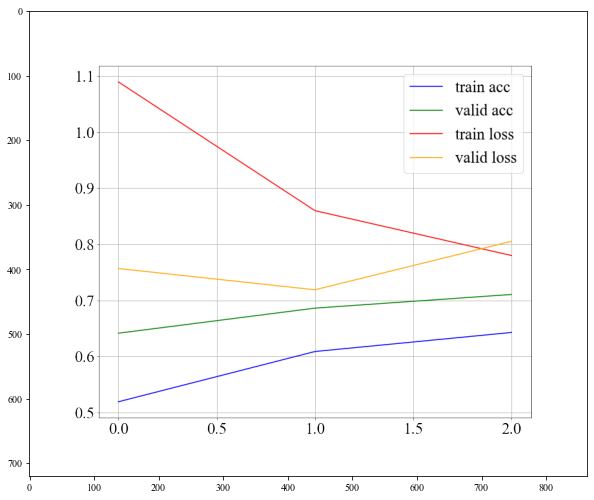

正答率: 0.7798098024871982


In [103]:
# 初期パラメータ
n_hidden     = 80  # 隠れ層のユニット数
epochs       = 100 # エポック数
batch_size   = 10  # ミニバッチサイズ
len_sequence = 80  # 参照する過去日数
predict_day  = 1   #予測日（何営業日後か）
dropout_rate = 0.5 #ドロップアウト割合
early_stopping_set = 0 # 早期終了のpatience
split_rate = 0.9 # 学習データの分割割合
verbose = 1

#データ整形と分割
data = CreateData(
            split_rate,
            len_sequence,
            predict_day
        )
(x_data,t_data) = data.create_train_target(read_file='N225.csv')
(x_train, x_test),(t_train, t_test) = data.split_train_test(x_data,t_data)

# モデル定義
prediction = Prediction(len_sequence, n_hidden, 1, 4, dropout_rate)

# 最適化実行
score = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set,verbose)

print("正答率:", score)


テストデータを利用した正答率は78%のため、これを超えるためのチューニングを以降で実施する。

### パラメータ値検証
検証する種類は以下のとおり。
* バッチサイズ(初期値＝10)
* 早期終了(初期値＝0)
* LSTMの参照する過去日数(初期値＝80)
* ドロップアウト率(初期値＝0.5)
* 隠れ層のユニット数(初期値＝80)

### 1. バッチサイズ

batch_size:2
Epoch 00002: early stopping
score: [0.7200171054711265, 0.753474771976471]


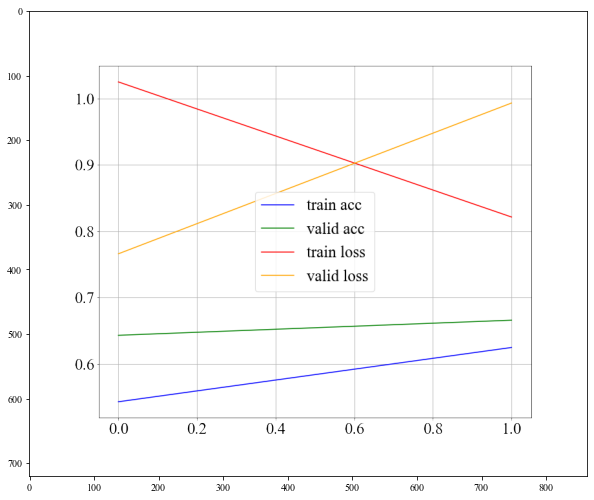

batch_size:5
Epoch 00002: early stopping
score: [0.6114865984541488, 0.7637161612510681]


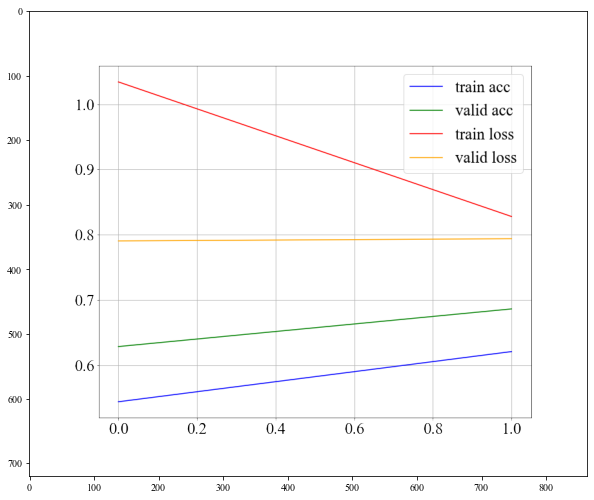

batch_size:10
Epoch 00002: early stopping
score: [0.6053923278196763, 0.7629846334457397]


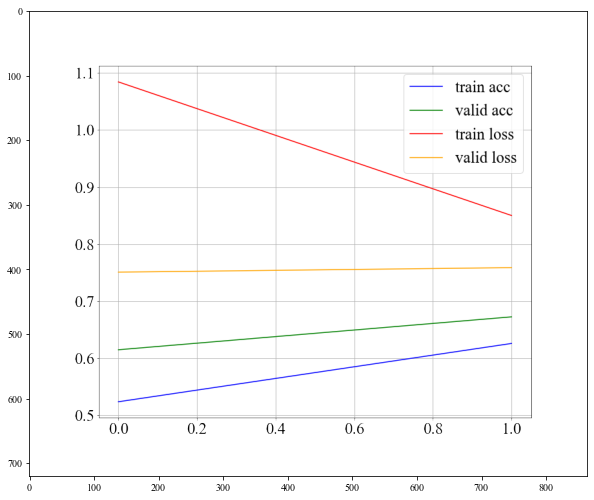

batch_size:20
Epoch 00004: early stopping
score: [0.5709500808565827, 0.7761521339416504]


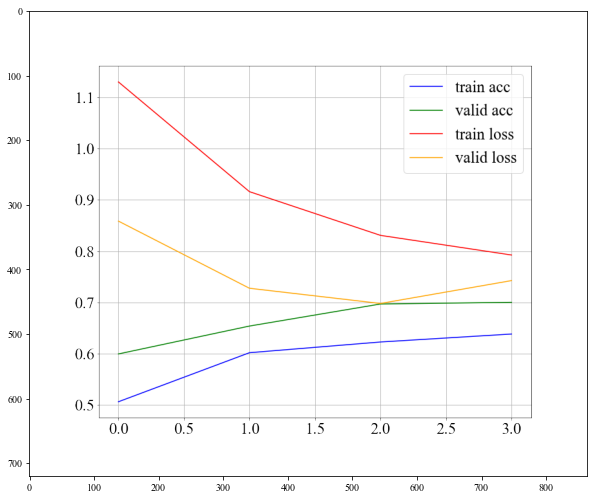

batch_size:50
Epoch 00004: early stopping
score: [0.6395125225153646, 0.7468910217285156]


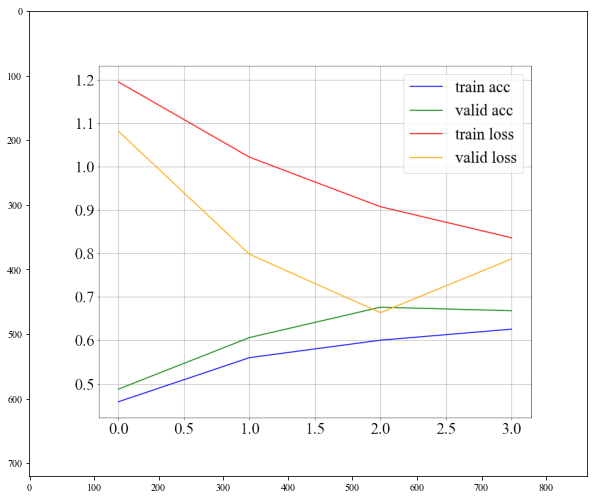

batch_size:100
Epoch 00005: early stopping
score: [0.5972439698607885, 0.7600585222244263]


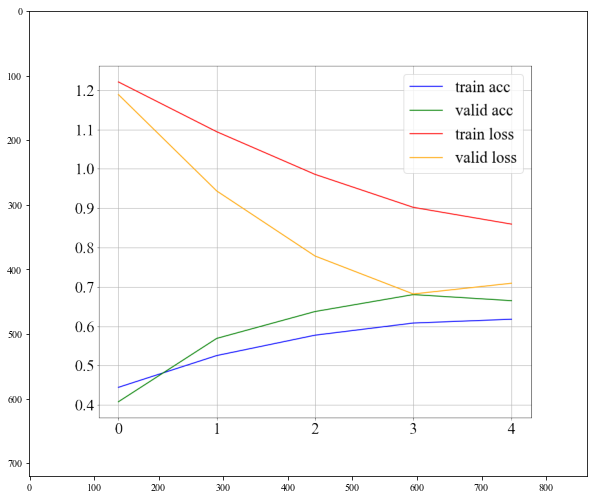

batch_size:150
Epoch 00006: early stopping
score: [0.6313870799044404, 0.7381126284599304]


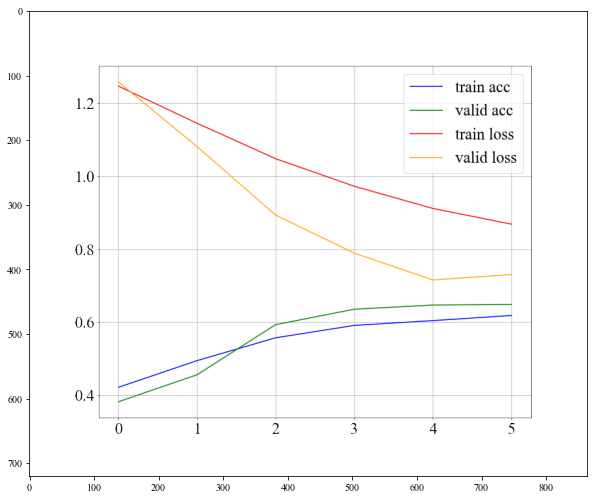

batch_size:200
Epoch 00007: early stopping
score: [0.6442087663292623, 0.7498171329498291]


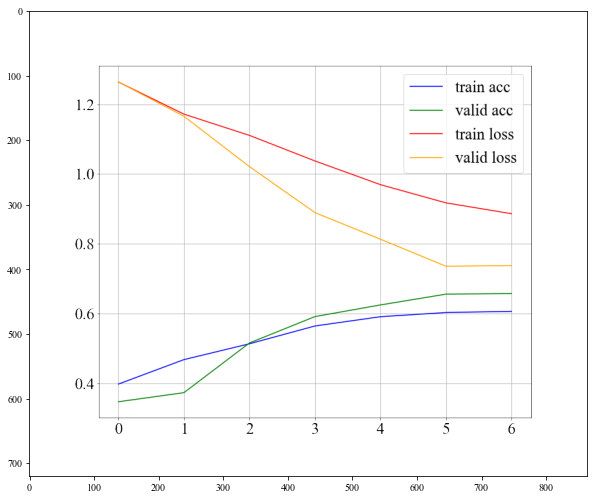

batch_size:300
Epoch 00009: early stopping
score: [0.6470174717484553, 0.7410387992858887]


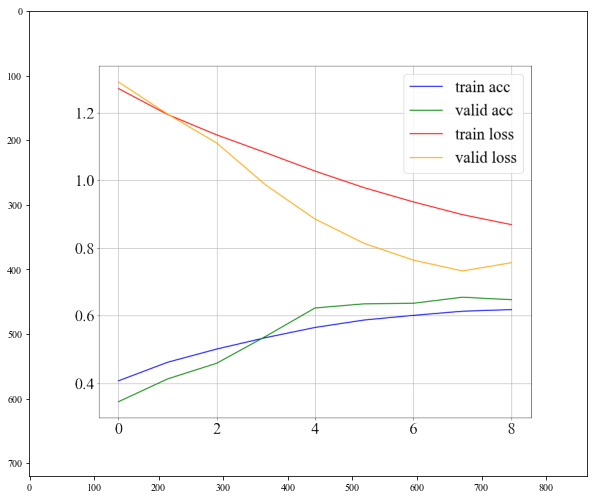

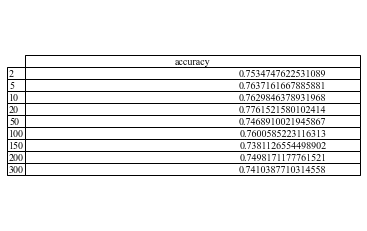

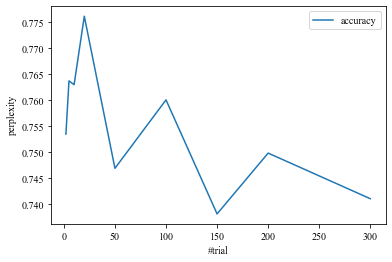

In [100]:
# パラメータ検証定義[バッチサイズ]
batch_size_list = [2,5,10,20,50,100,150,200,300] #検証パターン
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_batch_size(epochs, early_stopping_set,batch_size_list)

1. バッチサイズ10未満の場合、検証データの損失値（「valid loss」）が学習されないか、もしくは過学習の状態（訓練するほど上昇）になってしまう
2. バッチサイズ50以上の場合、テストデータの正答率が下降している。  

**⇒1,2より10または20がバッチサイズとして適切であると判断できる。**



### 2. 早期終了

early_stopping:0
Epoch 00003: early stopping
score: [0.5863066415609717, 0.775420606136322]


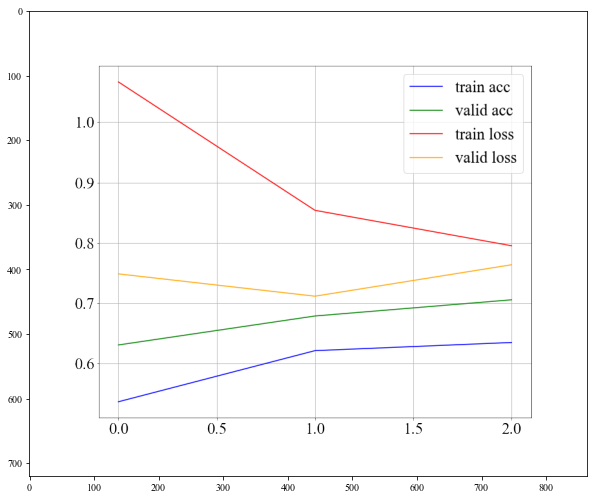

early_stopping:5
Epoch 00007: early stopping
score: [0.7936258090090418, 0.7834674715995789]


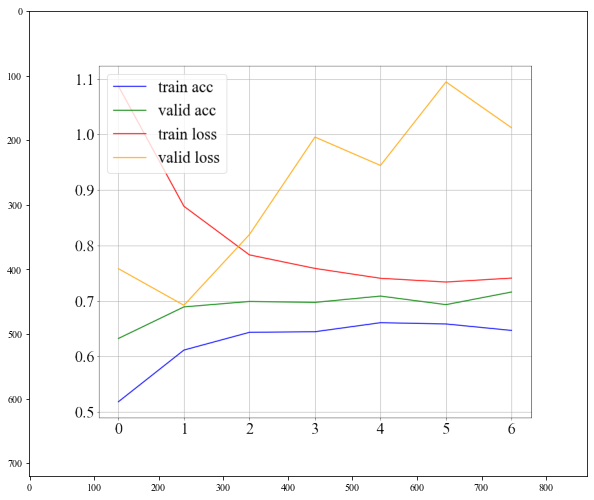

early_stopping:10
Epoch 00012: early stopping
score: [1.096890343183341, 0.7732260227203369]


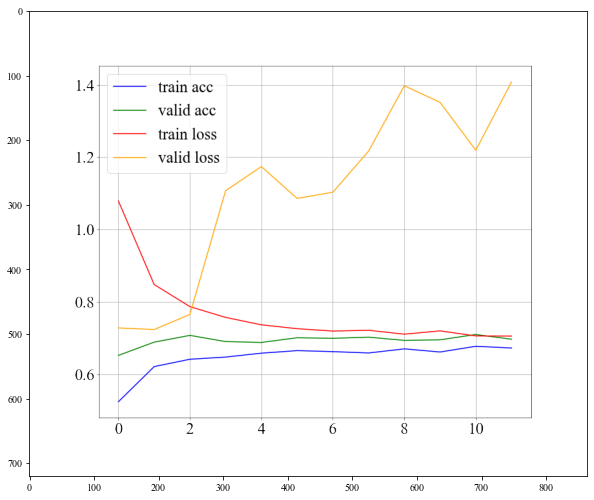

early_stopping:20
Epoch 00022: early stopping
score: [0.8577118601764797, 0.7973664999008179]


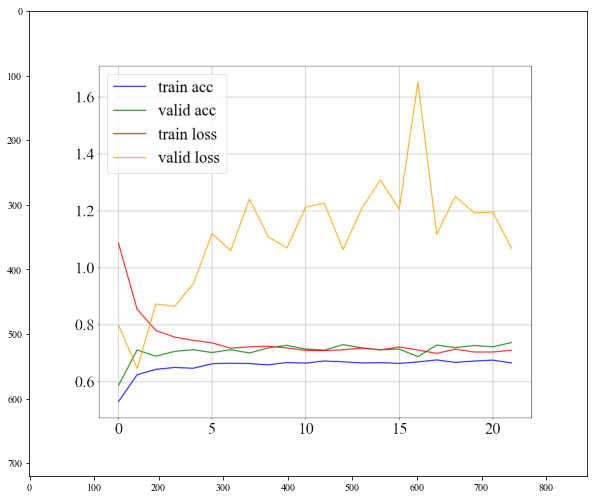

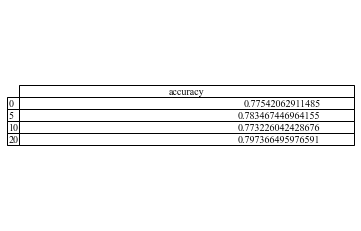

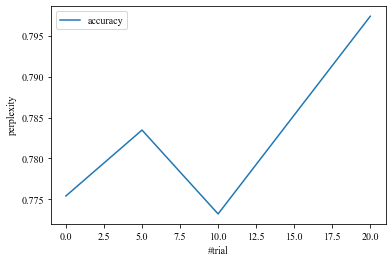

In [90]:
# パラメータ検証定義[早期終了]
early_stopping_list = [0, 5, 10 ,20]
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_early_stopping(batch_size, epochs, early_stopping_list)

1. patience5以上の場合、検証データの損失値（「valid loss」）が過学習の状態（訓練するほど上昇）になってしまう
2. patience5の場合にテストデータの正答率が一度頂点となり、その後10以上の場合、テストデータの正答率が上昇している。

**⇒1より５以上の場合に過学習の傾向が強くなるため、0または強いて5が最適と判断できる。**

### 3. LSTMの参照する過去日数

last_day_count:1
x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13745, 1, 1) (13745, 4)
(1374, 1, 1) (12371, 1, 1) (1374, 4) (12371, 4)
Epoch 00012: early stopping
score: [0.6041415726988677, 0.7520814538002014]


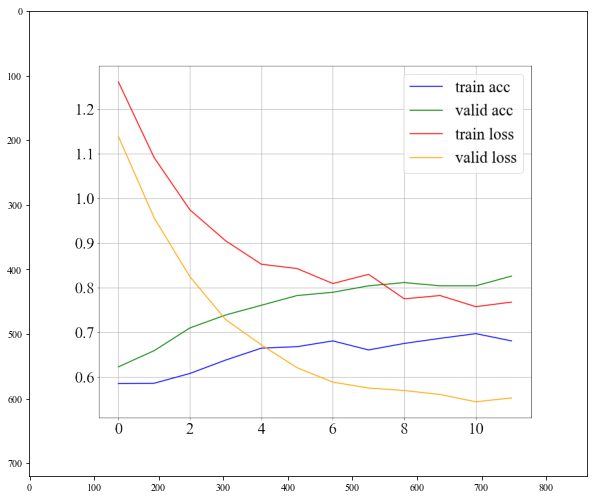

last_day_count:10
x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13736, 10, 1) (13736, 4)
(1373, 10, 1) (12363, 10, 1) (1373, 4) (12363, 4)
Epoch 00013: early stopping
score: [0.6925129436235505, 0.6995065808296204]


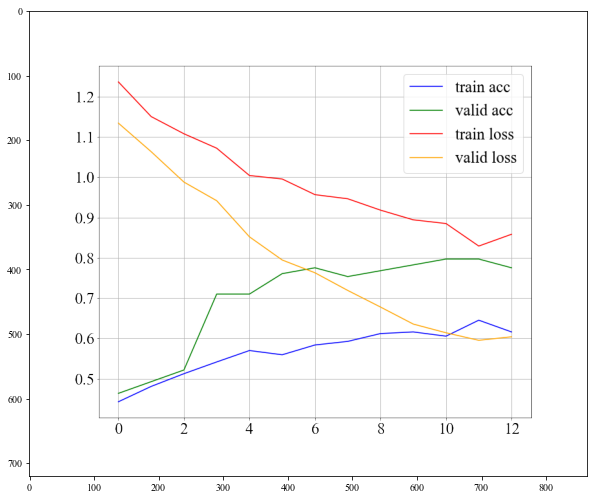

last_day_count:25
x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13721, 25, 1) (13721, 4)
(1372, 25, 1) (12349, 25, 1) (1372, 4) (12349, 4)
Epoch 00015: early stopping
score: [0.6436870173108521, 0.7021621465682983]


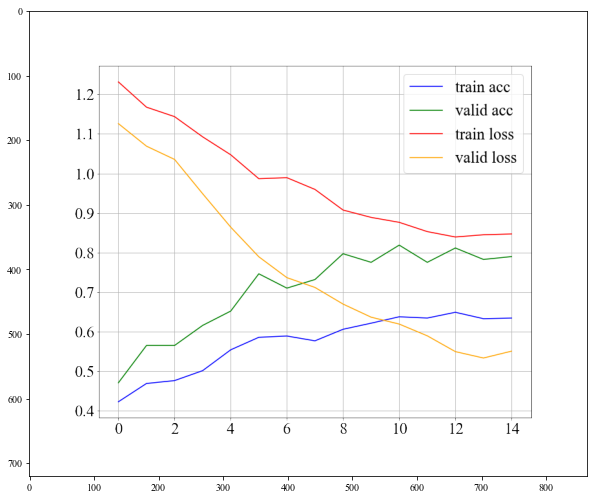

last_day_count:50
x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13696, 50, 1) (13696, 4)
(1369, 50, 1) (12327, 50, 1) (1369, 4) (12327, 4)
Epoch 00012: early stopping
score: [0.7243213269448855, 0.6835402250289917]


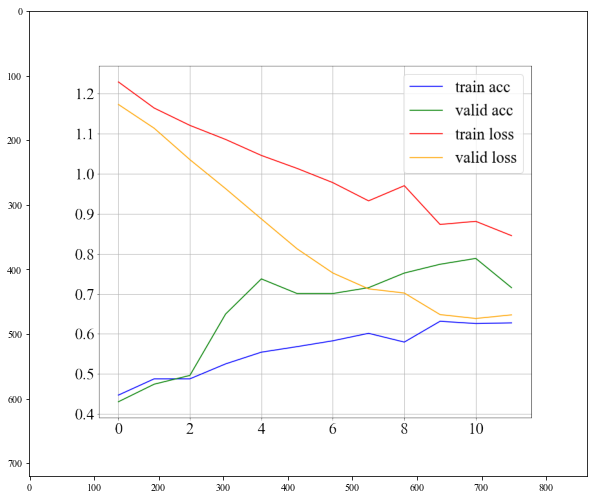

last_day_count:80
x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13666, 80, 1) (13666, 4)
(1366, 80, 1) (12300, 80, 1) (1366, 4) (12300, 4)
Epoch 00016: early stopping
score: [0.6176298099986421, 0.7421951293945312]


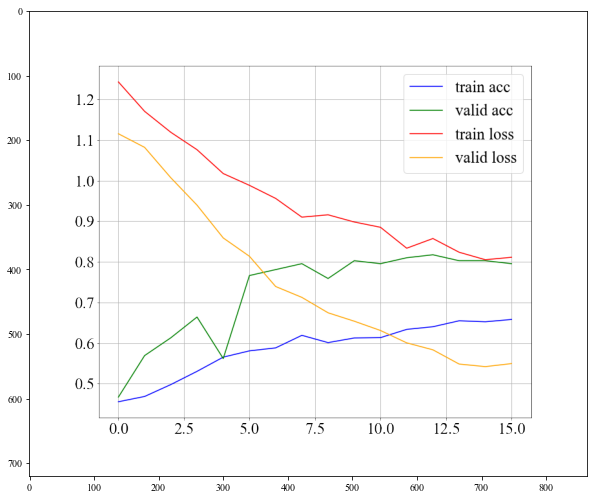

last_day_count:100
x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13646, 100, 1) (13646, 4)
(1364, 100, 1) (12282, 100, 1) (1364, 4) (12282, 4)
Epoch 00018: early stopping
score: [0.7218898326325952, 0.6840091347694397]


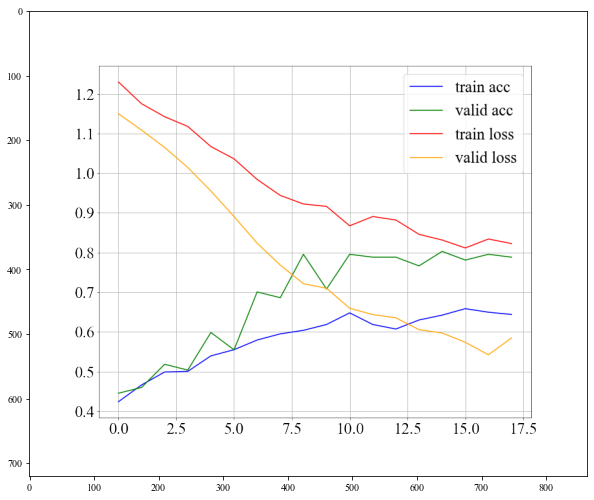

last_day_count:200
x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13546, 200, 1) (13546, 4)
(1354, 200, 1) (12192, 200, 1) (1354, 4) (12192, 4)
Epoch 00018: early stopping
score: [0.6998220082479981, 0.685531497001648]


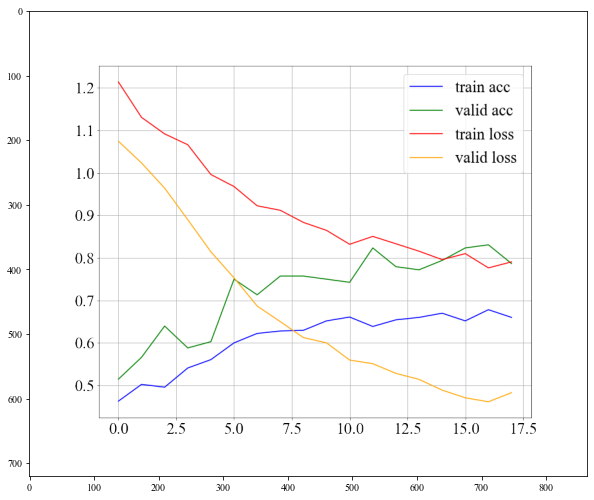

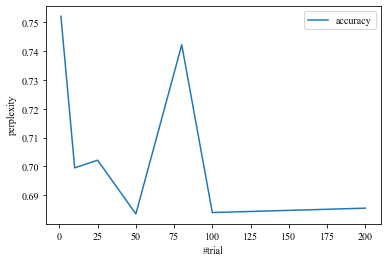

In [108]:
# パラメータ検証定義[参照する過去日数]
last_day_count_list = [1,10,25,50,80,100,200]
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_last_day_count(batch_size, epochs, early_stopping_set, 'N225.csv',last_day_count_list)

1. 学習状況に大きな差はでなかった。
2. 80の場合にテストデータの正答率が頂点となっている（または1）。

**⇒80を最適と判断する**

### 4. ドロップアウト

dropout_rate:0
Epoch 00005: early stopping
score: [0.08682884072955005, 0.9568397998809814]


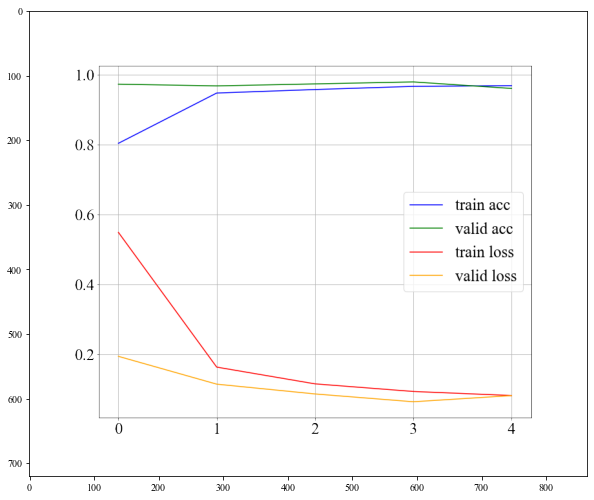

dropout_rate:0.1
Epoch 00003: early stopping
score: [0.1447669928702686, 0.9378200173377991]


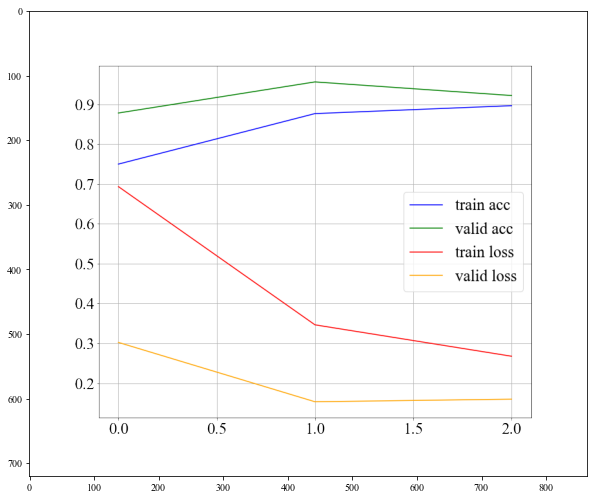

dropout_rate:0.25
Epoch 00004: early stopping
score: [0.3302309358514295, 0.8602780103683472]


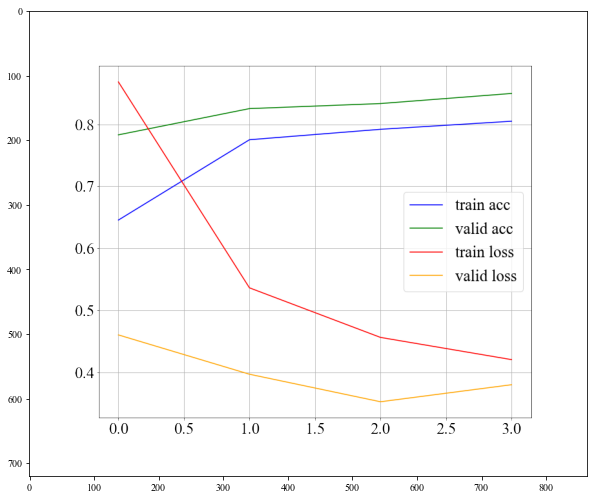

dropout_rate:0.5
Epoch 00003: early stopping
score: [0.69903329687347, 0.7600585222244263]


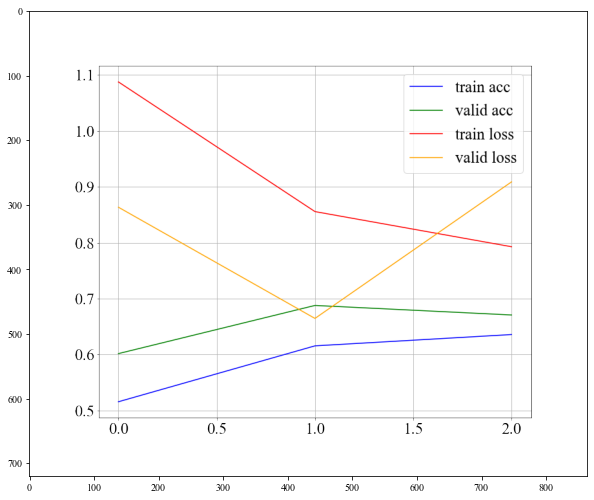

dropout_rate:0.75
Epoch 00004: early stopping
score: [0.9826641121569915, 0.6525237560272217]


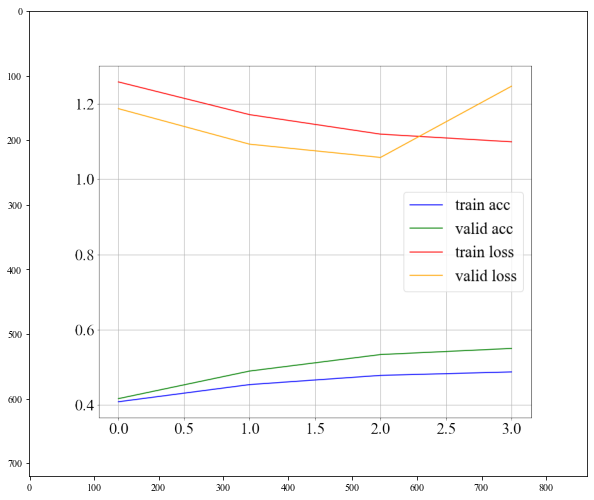

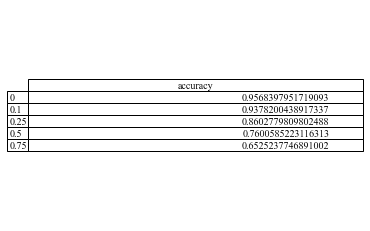

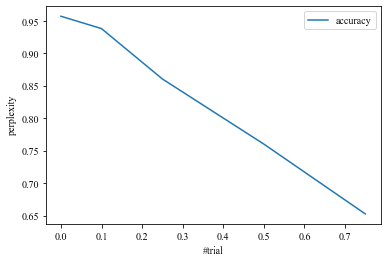

In [95]:
# パラメータ検証定義[ドロップアウト]
dropout_list = [0,0.1,0.25,0.5,0.75]
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_dropout_rate(batch_size, epochs, early_stopping_set, dropout_list)

1. 学習状況、テストデータの正答率ともにドロップアウト率が低いほうが良い結果となった。

**⇒今回に限り、0または0.1を最適と判断する**

### 5. 隠れ層のユニット数

hidden_unit:10
Epoch 00009: early stopping
score: [0.3582519676364511, 0.8594436049461365]


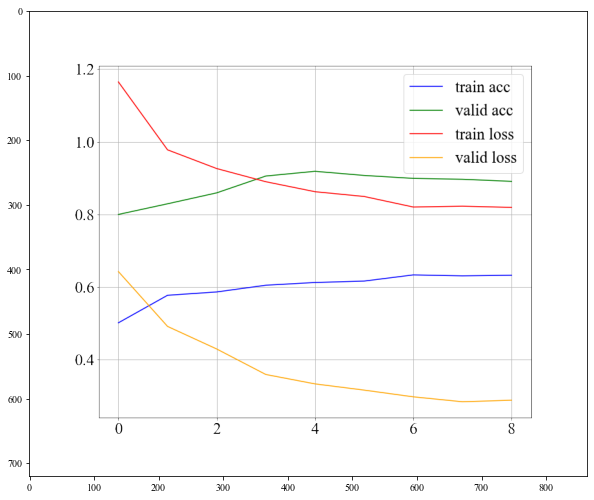

hidden_unit:25
Epoch 00005: early stopping
score: [0.4214988207730218, 0.7957540154457092]


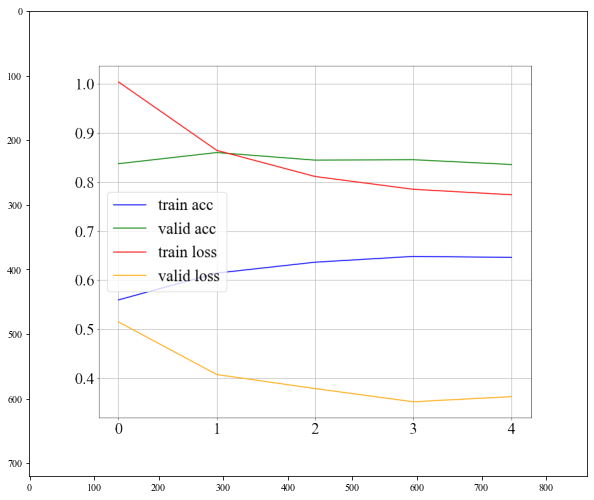

hidden_unit:50
Epoch 00004: early stopping
score: [0.5457297076170652, 0.7474377751350403]


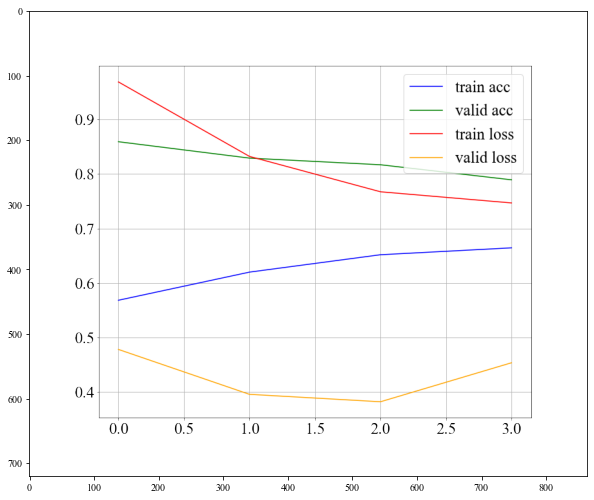

hidden_unit:80
Epoch 00004: early stopping
score: [0.5422741700900138, 0.751098096370697]


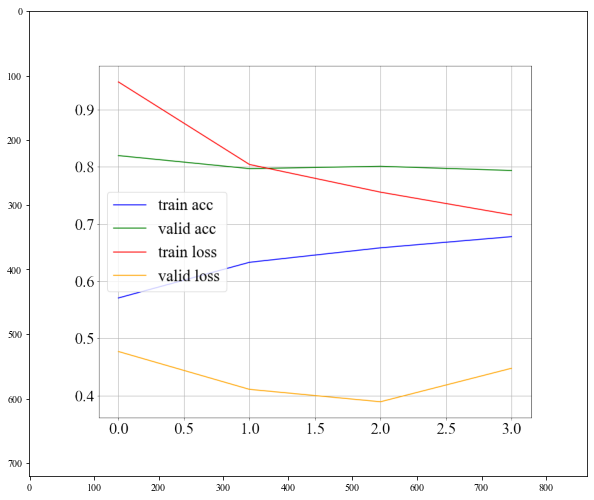

hidden_unit:100
Epoch 00003: early stopping
score: [0.586916912721657, 0.7452415823936462]


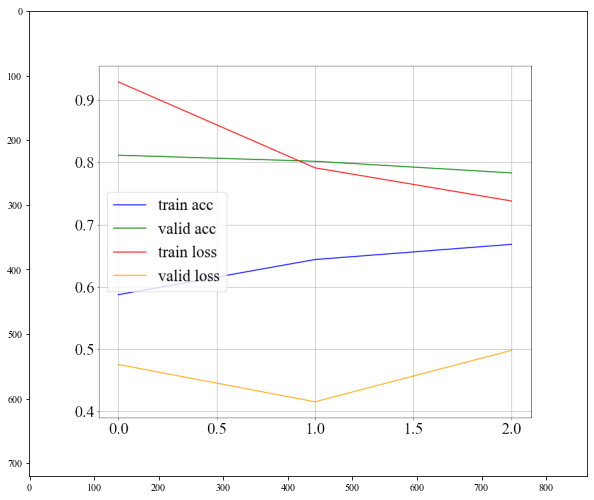

hidden_unit:150
Epoch 00003: early stopping
score: [0.6338177400456506, 0.732064425945282]


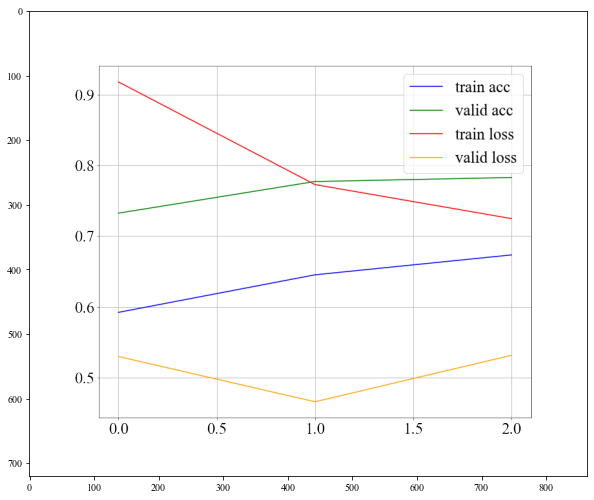

hidden_unit:200
Epoch 00003: early stopping
score: [0.5532970502195258, 0.7598828673362732]


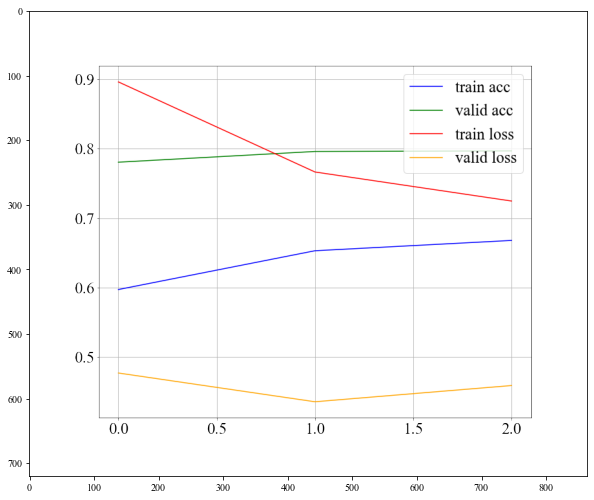

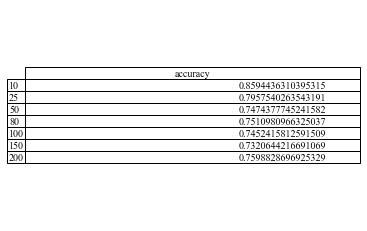

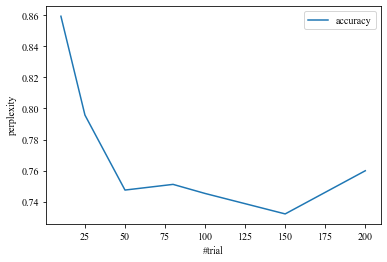

In [49]:
# パラメータ検証定義[隠れ層のユニット数]
hidden_unit_list = [10,25,50,80,100,150,200]
search = OptimizeSearch(prediction,x_train, t_train, x_test, t_test)
search.search_hidden_unit(batch_size, epochs, hidden_unit_list)

1. テストデータの正答率はユニット数20から下降傾向にある。

**⇒10を最適と判断する**

### 検証結果をもとにパラメータを最適化して実行

x_data.shape= (13745,)
================ x_data =====================
[ 0.49852266  0.81329995  0.95427451 ... -1.10122126 -0.36458438
 -0.41729455]
================ x_data =====================
t_data.shape= (13745, 4)
================ t_data =====================
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
================ t_data =====================
(13666, 80, 1) (13666, 4)
(12299, 80, 1) (1367, 80, 1) (12299, 4) (1367, 4)
Train on 11069 samples, validate on 1230 samples
Epoch 1/100
11069/11069 [==============================] - 24s 2ms/step - loss: 0.9093 - accuracy: 0.6343 - val_loss: 0.6383 - val_accuracy: 0.7927
Epoch 2/100
11069/11069 [==============================] - 23s 2ms/step - loss: 0.4030 - accuracy: 0.8850 - val_loss: 0.2756 - val_accuracy: 0.9447
Epoch 3/100
11069/11069 [==============================] - 23s 2ms/step - loss: 0.2055 - accuracy: 0.9486 - val_loss: 0.1547 - val_accuracy: 0.9618
Epoch 4/100
11069/11069 

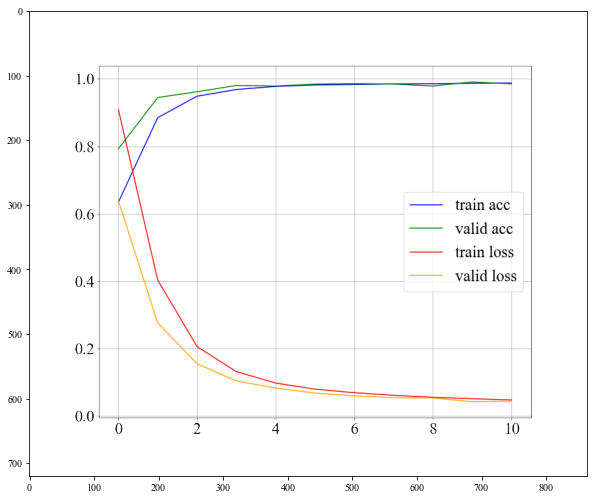

正答率: 0.978054133138259


In [47]:
# 初期パラメータ
n_hidden     = 10  # 隠れ層のユニット数
epochs       = 100 # エポック数
batch_size   = 10 # ミニバッチサイズ
len_sequence = 80  # 参照する過去日数
predict_day  = 1   #予測日（何営業日後か）
dropout_rate = 0.0 #ドロップアウト割合
early_stopping_set = 0 # 早期終了のpatience
split_rate = 0.9 # 学習データの分割割合
verbose = 1

#データ整形と分割
data = CreateData(
            split_rate,
            len_sequence,
            predict_day
        )
(x_data,t_data) = data.create_train_target(read_file='N225.csv')
(x_train, x_test),(t_train, t_test) = data.split_train_test(x_data,t_data)

# モデル定義
prediction = Prediction(len_sequence, n_hidden, 1, 4, dropout_rate)

# 最適化実行
score = prediction.optimize(x_train, t_train, x_test, t_test, batch_size, epochs, early_stopping_set,verbose)

# 保存
prediction.save()

print("正答率:", score)

#### このモデルを利用して10営業日後の予測も実施してみる。

In [48]:
batch_size   = 20 # ミニバッチサイズ
predict_day  = 10 #予測日（何営業日後か）
len_sequence = 80 # 参照する過去日数
split_rate = 0.9  # 学習データの分割割合

#データ整形と分割
data = CreateData(
            split_rate,
            len_sequence,
            predict_day
        )
(x_data,t_data) = data.create_train_target(read_file='N225.csv')
(x_train, x_test),(t_train, t_test) = data.split_train_test(x_data,t_data)

# モデル定義
prediction = Prediction(0, 0, 0, 0, 0)

# 読み込み
prediction.load()

# テスト
score = prediction.evaluate(x_test, t_test, batch_size)

# 正答率集計
pred = prediction.scoring(x_test, t_test)

print("正答率:", pred)

x_data.shape= (13736,)
================ x_data =====================
[ 1.01294329 -0.17089012 -1.92659708 ...  8.57940655  6.34326003
  4.94194155]
================ x_data =====================
t_data.shape= (13736, 4)
================ t_data =====================
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]
================ t_data =====================
(13657, 80, 1) (13657, 4)
(12291, 80, 1) (1366, 80, 1) (12291, 4) (1366, 4)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                480       
_________________________________________________________________
dropout_8 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 44        
_________________________________